# Hotdog/Not-Hotdog Classifier Using Transfer Learning

In [1]:
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()

In [3]:
data_path = "/floyd/input/hotdog3"
batch_size = 32

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
train_generator = datagen.flow_from_directory(
        data_path+'/train',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None,  
        shuffle=False)

Found 15000 images belonging to 2 classes.


## Creating Inception Net bottleneck features for train and test sets

In [6]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 20s 0us/step


In [7]:
bottleneck_features_train = model.predict_generator(train_generator, 15000/batch_size, verbose=1)

469/468 [==============================] - 170s 362ms/step


In [8]:
bottleneck_features_train.shape

(15000, 8, 8, 2048)

In [9]:
np.savez('inception_features_train', features=bottleneck_features_train)

In [10]:
test_generator = datagen.flow_from_directory(
        data_path+'/test',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 644 images belonging to 2 classes.


In [11]:
bottleneck_features_test = model.predict_generator(test_generator, 644/batch_size, verbose=1)
np.savez('inception_features_test', features=bottleneck_features_test)

21/20 [===============================] - 8s 373ms/step


In [12]:
train_data = np.load('inception_features_train.npz')['features']

In [13]:
train_data.shape

(15000, 8, 8, 2048)

In [14]:
train_labels = np.array([0] * 7500 + [1] * 7500)

In [15]:
train_labels.shape

(15000,)

In [16]:
test_data = np.load('inception_features_test.npz')['features']
test_labels = np.array([0] * 322 + [1] * 322)

In [17]:
classes = test_generator.class_indices
class_names = []
for key in classes.keys():
    class_names.append(key)
print(class_names)

['hotdog', 'nothotdog']


## Defining and training the Model

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=train_data.shape[1:], padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [20]:
checkpointer = ModelCheckpoint(filepath='/floyd/home/weights_inception.hdf5', verbose=1, save_best_only=True)

In [21]:
keras.utils.print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 8, 8, 32)          589856    
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 2, 2, 64)          18496     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [22]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history = model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_split=0.3,
          verbose=2,
          callbacks=[checkpointer], shuffle=True)


Train on 10500 samples, validate on 4500 samples
Epoch 1/50
 - 15s - loss: 0.2420 - binary_accuracy: 0.9075 - val_loss: 0.1524 - val_binary_accuracy: 0.9484

Epoch 00001: val_loss improved from inf to 0.15243, saving model to /floyd/home/weights_inception.hdf5
Epoch 2/50
 - 7s - loss: 0.1698 - binary_accuracy: 0.9401 - val_loss: 0.1457 - val_binary_accuracy: 0.9356

Epoch 00002: val_loss improved from 0.15243 to 0.14566, saving model to /floyd/home/weights_inception.hdf5
Epoch 3/50
 - 7s - loss: 0.1289 - binary_accuracy: 0.9561 - val_loss: 0.4597 - val_binary_accuracy: 0.7978

Epoch 00003: val_loss did not improve from 0.14566
Epoch 4/50
 - 7s - loss: 0.1004 - binary_accuracy: 0.9664 - val_loss: 0.2292 - val_binary_accuracy: 0.8793

Epoch 00004: val_loss did not improve from 0.14566
Epoch 5/50
 - 7s - loss: 0.0899 - binary_accuracy: 0.9698 - val_loss: 0.1975 - val_binary_accuracy: 0.8942

Epoch 00005: val_loss did not improve from 0.14566
Epoch 6/50
 - 7s - loss: 0.0806 - binary_accura

In [23]:
model.load_weights('/floyd/home/weights_inception.hdf5')

In [24]:
rounded_predictions = model.predict_classes(test_data, batch_size=32, verbose=1)

644/644 [==============================] - 1s 1ms/step


## Creating Metrics

### Accuracy

In [25]:
model.evaluate(test_data,test_labels, verbose=1,batch_size=batch_size)

644/644 [==============================] - 0s 454us/step


[0.11444860420288136, 0.9642857142857143]

### Confusion Matrix

<function matplotlib.pyplot.show(*args, **kw)>

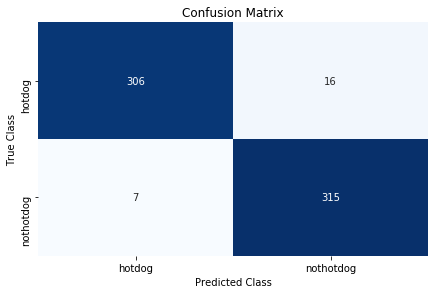

In [26]:
#Confusion Matrix
matrix = confusion_matrix(test_labels, rounded_predictions)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show

### Plotting training/validation accuracy and loss over the epochs

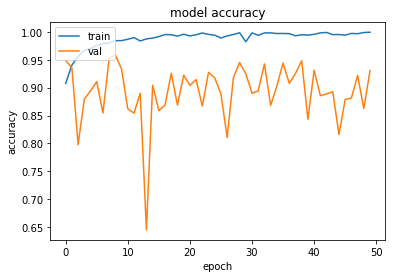

In [28]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'] )
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

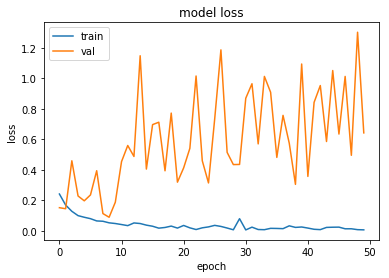

In [29]:
# summarize history for loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Finding out incorrectly classified images

In [30]:
incorrect_labels = []
incorrect_classification_indices = []
for i in range(rounded_predictions.shape[0]):
    if not rounded_predictions[i] == test_labels[i]:
        incorrect_classification_indices.append(i)
        incorrect_labels.append(rounded_predictions[i][0])

In [31]:
incorrect_classification_file_paths = []
for i in range(len(incorrect_classification_indices)):
    if incorrect_classification_indices[i] < 322:
        incorrect_classification_file_paths.append('hotdog/'+ os.listdir('/floyd/input/hotdog3/test/hotdog')[i])
    else:
        incorrect_classification_file_paths.append('nothotdog/'+ os.listdir('/floyd/input/hotdog3/test/nothotdog')[i])

In [32]:
print(cv2.__version__)
img_path = data_path + '/test/'
def get_image(file_path):
    if os.path.isfile(img_path + file_path):
        image_bgr = cv2.imread(img_path + file_path,cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image_rgb_resized = cv2.resize(image_rgb, (299, 299), interpolation = cv2.INTER_CUBIC)
        plt.imshow(image_rgb_resized)
        plt.axis("off")
        plt.show()

3.4.0


### Plotting a few incorrectly classified images

True:hotdog
Pred:Not Hotdog


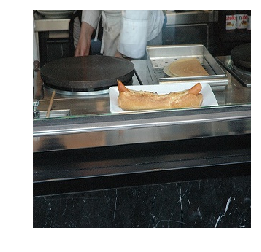

True:hotdog
Pred:Not Hotdog


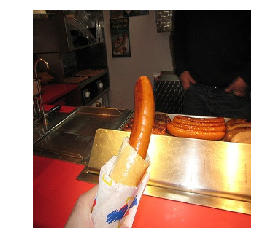

True:not hotdog
Pred:Hotdog


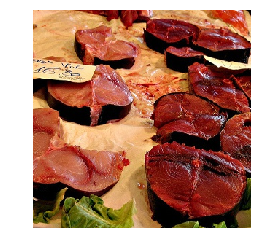

In [33]:
for i in range(0, len(incorrect_classification_file_paths), 10):
    if 'nothotdog' in incorrect_classification_file_paths[i]:
        print("True:not hotdog")
    else:
        print("True:hotdog")
        
    if incorrect_labels[i] == 1:
        print("Pred:Not Hotdog")
    else:
        print("Pred:Hotdog")
    get_image(incorrect_classification_file_paths[i])